In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
df = pd.read_csv('server/data-12-22-18.csv')
df['correct'] = (df.true == df.pred)
df['(true=1,pred=1)'] = (df.true == 1) &  (df.pred == 1)
df['(true=1,pred=0)'] = (df.true == 1) &  (df.pred == 0)
df['(true=0,pred=1)'] = (df.true == 0) &  (df.pred == 1)
df['(true=0,pred=0)'] = (df.true == 0) &  (df.pred == 0)
df = df[df.gender.isin(['male', 'female'])]

df.head()

,id,uid,expt_id,duration,true,pred,age,gender,expert,filename,correct,"(true=1,pred=1)","(true=1,pred=0)","(true=0,pred=1)","(true=0,pred=0)"
0,1,df28d326ca098ebc03e58dbfbf256259,2,1000,1,0,18,male,0,real-blur/real-blur-41.jpg,False,False,True,False,False
1,2,df28d326ca098ebc03e58dbfbf256259,2,1000,0,0,18,male,0,gan-blur/gan-blur-9.jpg,True,False,False,False,True
2,3,df28d326ca098ebc03e58dbfbf256259,2,1000,1,1,18,male,0,real-blur/real-blur-6.jpg,True,True,False,False,False
3,4,df28d326ca098ebc03e58dbfbf256259,2,1000,0,0,18,male,0,gan-blur/gan-blur-31.jpg,True,False,False,False,True
4,5,df28d326ca098ebc03e58dbfbf256259,2,1000,1,1,18,male,0,real-blur/real-blur-27.jpg,True,True,False,False,False


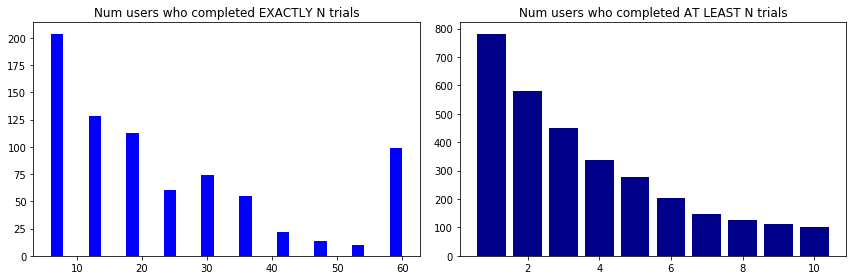

In [3]:
effort = df.groupby('uid').id.nunique().tolist()
remaining = [np.sum(np.array(effort) >= 6*n) for n in range(1,11)]

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(effort, bins=28, range=(6,60), color="blue")
ax2.bar(range(1,11), remaining, color="darkblue")

ax1.set_title("Num users who completed EXACTLY N trials")
ax2.set_title("Num users who completed AT LEAST N trials")

fig.tight_layout()
plt.show()

In [4]:
print ("Exp 1 datapoints: %d" % df[df.expt_id==1].id.count())
print ("Exp 2 datapoints: %d" % df[df.expt_id==2].id.count())
print ("started users: %d, completed users: %d" % (df.uid.nunique(), np.sum(df.groupby('uid').id.nunique() >= 60)))
print ("experts: %d, non-experts: %d" % (df[df.expert==1].uid.nunique(), df[df.expert==0].uid.nunique()))
print ("men: %d, women: %d" % (df[df.gender=='male'].uid.nunique(), df[df.gender=='female'].uid.nunique()))
print ("---------------------------------------------")
print(df[df.gender != 'other'].groupby(["expt_id", "duration"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))
print(df[df.gender != 'other'].groupby(["expt_id", "duration", "gender"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))

Exp 1 datapoints: 9108
Exp 2 datapoints: 9738
started users: 783, completed users: 103
experts: 312, non-experts: 471
men: 679, women: 104
---------------------------------------------
   expt_id  duration    id
4        1      5000  1824
3        1      2000  1788
2        1      1000  1818
1        1       500  1842
0        1       250  1836
9        2      5000  1986
8        2      2000  1938
7        2      1000  1884
6        2       500  1932
5        2       250  1998
    expt_id  duration  gender    id
8         1      5000  female   294
9         1      5000    male  1530
6         1      2000  female   324
7         1      2000    male  1464
4         1      1000  female   282
5         1      1000    male  1536
2         1       500  female   306
3         1       500    male  1536
0         1       250  female   312
1         1       250    male  1524
18        2      5000  female   264
19        2      5000    male  1722
16        2      2000  female   288
17        2   

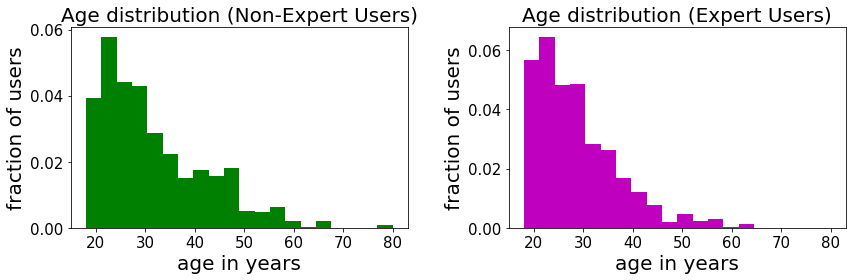

In [14]:
fs = 20
tfs = 15
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Age distribution (Non-Expert Users)", fontsize=fs)
ax2.set_title("Age distribution (Expert Users)", fontsize=fs)
ax1.set_xlabel("age in years", fontsize=fs)
ax2.set_xlabel("age in years", fontsize=fs)
ax1.set_ylabel("fraction of users", fontsize=fs)
ax2.set_ylabel("fraction of users", fontsize=fs)
ax1.hist(df[df.expert==0].age, bins=20, range=(18,80), color="g", density=True)
ax2.hist(df[df.expert==1].age, bins=20, range=(18,80), color="m", density=True)

ax1.xaxis.set_tick_params(labelsize=tfs)
ax1.yaxis.set_tick_params(labelsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)
fig.tight_layout()
plt.show()

In [6]:
expt_id1 = 1
expt_id2 = 1
dur1 = 5000
dur2 = 5000
g1 = 'male'
g2 = 'female'
e1 = True
e2 = True

exp1_data = df[(df.expt_id==expt_id1) & (df.duration==dur1) & (df.gender==g1) & (df.expert==e1)].correct
exp2_data = df[(df.expt_id==expt_id2) & (df.duration==dur2) & (df.gender==g2) & (df.expert==e2)].correct

print (exp1_data.mean())
print (exp2_data.mean())


from scipy.stats import ttest_ind

print (ttest_ind(exp1_data, exp2_data))

0.7183908045977011
0.75
Ttest_indResult(statistic=-0.61005260778681, pvalue=0.5420050998668736)


In [7]:
def conf_interval(N, p_success):
    return (1.96/N)*np.sqrt(p_success*(1-p_success)*N) #95% conf interval


def get_results(df, columns):
    results = df.groupby(columns).agg({
        'uid': 'nunique',
        'id': 'nunique',
        'true': 'sum',
        'correct': 'sum',
        '(true=1,pred=1)': 'sum',
        '(true=0,pred=1)':'sum',
        '(true=1,pred=0)': 'sum',
        '(true=0,pred=0)': 'sum',
    }).reset_index()
    
    results['accuracy'] = results.correct / results.id   
    results['accuracy_conf'] = conf_interval(results.id, results.accuracy)
    
    results['(pred=1|true=1)'] = results['(true=1,pred=1)'] / results.true
    results['(pred=0|true=1)'] = results['(true=1,pred=0)'] / results.true
    results['(pred=1|true=0)'] = results['(true=0,pred=1)'] / (results.id - results.true)
    results['(pred=0|true=0)'] = results['(true=0,pred=0)'] / (results.id - results.true)

    results['(pred=1|true=1)_conf'] = conf_interval(results.true, results['(pred=1|true=1)'])
    results['(pred=0|true=1)_conf'] = conf_interval(results.true, results['(pred=0|true=1)'])
    results['(pred=1|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=1|true=0)'])
    results['(pred=0|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=0|true=0)'])

    return results

results = get_results(df, ['expt_id', 'duration'])
expert_results = get_results(df, ['expt_id', 'duration', 'expert'])
gender_results = get_results(df, ['expt_id', 'duration', 'gender'])
expert_gender_results = get_results(df, ['expt_id', 'duration', 'expert', 'gender'])

results

,expt_id,duration,uid,id,true,correct,"(true=1,pred=1)","(true=0,pred=1)","(true=1,pred=0)","(true=0,pred=0)",accuracy,accuracy_conf,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0),(pred=1|true=1)_conf,(pred=0|true=1)_conf,(pred=1|true=0)_conf,(pred=0|true=0)_conf
0,1,250,305,1836,892,1032.0,530.0,442.0,362.0,502.0,0.562092,0.022694,0.594170,0.405830,0.468220,0.531780,0.032226,0.032226,0.031832,0.031832
1,1,500,305,1842,920,1110.0,537.0,349.0,383.0,573.0,0.602606,0.022348,0.583696,0.416304,0.378525,0.621475,0.031854,0.031854,0.031308,0.031308
2,1,1000,302,1818,918,1181.0,555.0,274.0,363.0,626.0,0.649615,0.021931,0.604575,0.395425,0.304444,0.695556,0.031629,0.031629,0.030065,0.030065
3,1,2000,296,1788,919,1210.0,585.0,244.0,334.0,625.0,0.676734,0.021680,0.636561,0.363439,0.280783,0.719217,0.031098,0.031098,0.029879,0.029879
4,1,5000,302,1824,894,1267.0,587.0,250.0,307.0,680.0,0.694627,0.021137,0.656600,0.343400,0.268817,0.731183,0.031127,0.031127,0.028494,0.028494
5,2,250,330,1998,1012,1095.0,565.0,456.0,447.0,530.0,0.548048,0.021823,0.558300,0.441700,0.462475,0.537525,0.030596,0.030596,0.031122,0.031122
6,2,500,321,1932,953,1083.0,515.0,411.0,438.0,568.0,0.560559,0.022132,0.540399,0.459601,0.419816,0.580184,0.031642,0.031642,0.030916,0.030916
7,2,1000,312,1884,969,1172.0,560.0,303.0,409.0,612.0,0.622081,0.021895,0.577915,0.422085,0.331148,0.668852,0.031098,0.031098,0.030494,0.030494
8,2,2000,322,1938,927,1271.0,554.0,294.0,373.0,717.0,0.655831,0.021152,0.597627,0.402373,0.290801,0.709199,0.031568,0.031568,0.027994,0.027994
9,2,5000,329,1986,1034,1349.0,643.0,246.0,391.0,706.0,0.679255,0.020529,0.621857,0.378143,0.258403,0.741597,0.029558,0.029558,0.027808,0.027808


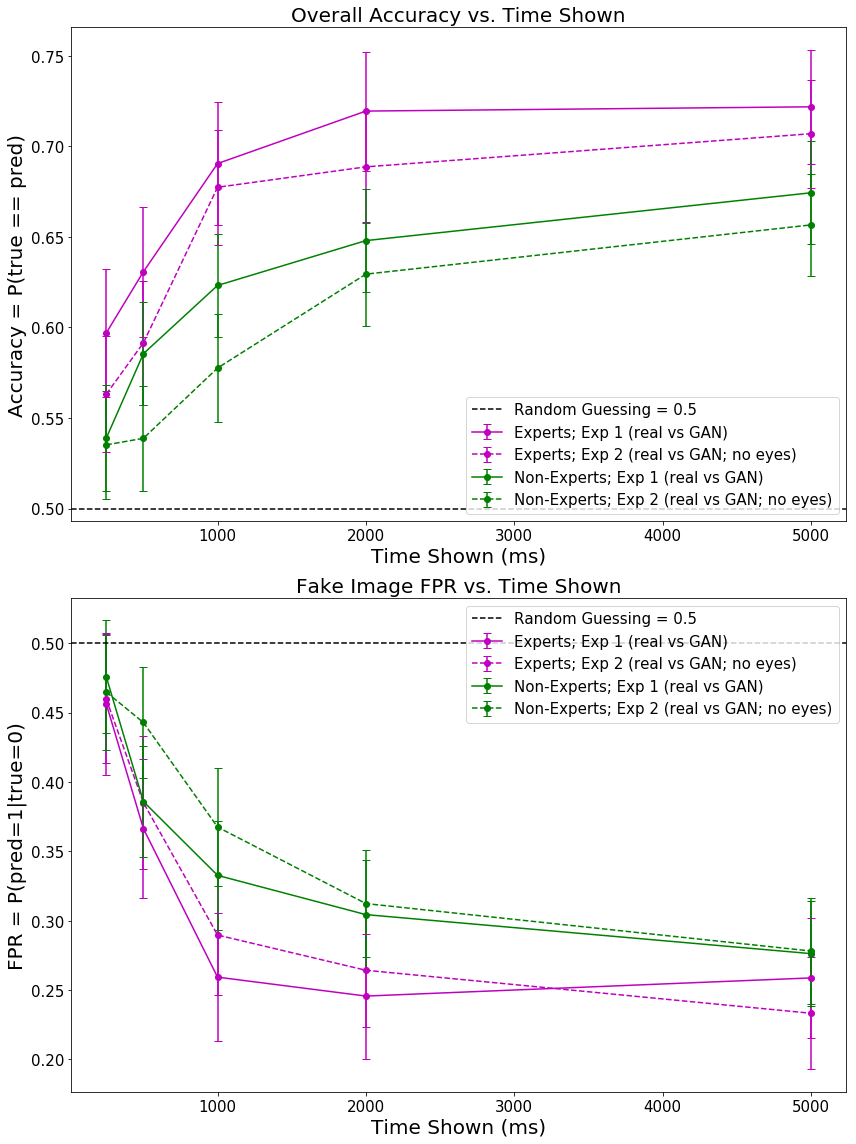

In [8]:
fig = plt.figure(figsize=(12,16))
fs = 20
tfs = 15

ax1 = fig.add_subplot(211)
ax1.set_title("Overall Accuracy vs. Time Shown", fontsize=fs)
ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)
ax2 = fig.add_subplot(212)
ax2.set_title("Fake Image FPR vs. Time Shown", fontsize=fs)
ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

id_map = [
    (1, "Experts; Exp 1 (real vs GAN)", "m", "-", True), 
    (2, "Experts; Exp 2 (real vs GAN; no eyes)", "m", "--", True),
    (1, "Non-Experts; Exp 1 (real vs GAN)", "g", "-", False), 
    (2, "Non-Experts; Exp 2 (real vs GAN; no eyes)", "g", "--", False)
]

for (expt_id, label, color, linestyle, expert)  in id_map:
    exp_data = expert_results[(expert_results.expt_id == expt_id) & (expert_results.expert == expert)]
    ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)

ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax1.legend(loc=0, fontsize=tfs)
ax1.xaxis.set_tick_params(labelsize=tfs)
ax1.yaxis.set_tick_params(labelsize=tfs)

ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.legend(loc=0, fontsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)

plt.tight_layout()
plt.show()

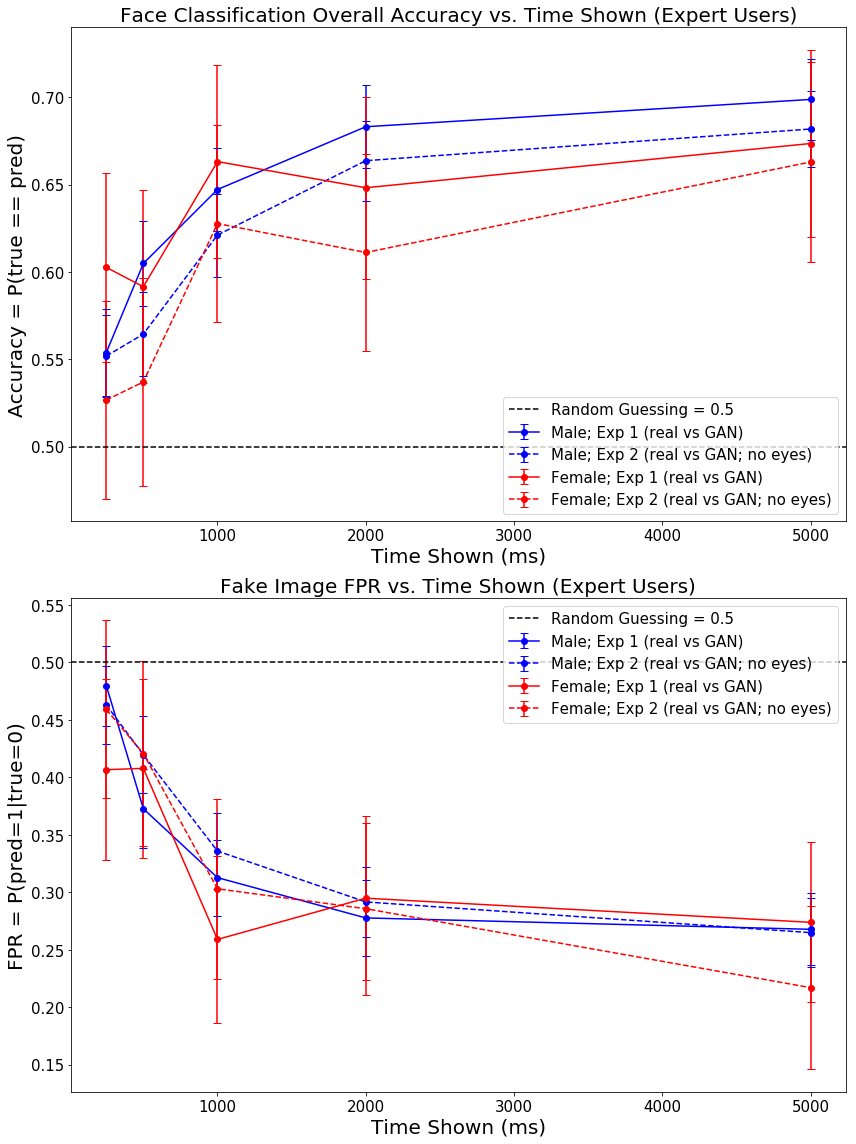

In [9]:
fs = 20
tfs = 15

fig = plt.figure(figsize=(12,16))
ax1 = fig.add_subplot(211)
ax1.set_title("Face Classification Overall Accuracy vs. Time Shown (Expert Users)", fontsize=fs)
ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)
ax2 = fig.add_subplot(212)
ax2.set_title("Fake Image FPR vs. Time Shown (Expert Users)", fontsize=fs)
ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

gender_id_map = {
    ('male', 1):("Male; Exp 1 (real vs GAN)", "b", "-"), 
    ('male', 2):("Male; Exp 2 (real vs GAN; no eyes)", "b", "--"),
    ('female', 1):("Female; Exp 1 (real vs GAN)", "r", "-"), 
    ('female', 2):("Female; Exp 2 (real vs GAN; no eyes)", "r", "--")
}

expert_filter = None

for (gender, expt_id), (label, color, linestyle)  in gender_id_map.items():
    if expert_filter is not None:
        exp_data = expert_gender_results[(expert_gender_results.expert == expert_filter) &
                                         (expert_gender_results.gender == gender) & 
                                         (expert_gender_results.expt_id == expt_id)]
    else:
        exp_data = gender_results[(gender_results.gender == gender) & 
                                  (gender_results.expt_id == expt_id)]
        
    ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)


ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax1.legend(loc=0, fontsize=tfs)
ax1.xaxis.set_tick_params(labelsize=tfs)
ax1.yaxis.set_tick_params(labelsize=tfs)

ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.legend(loc=0, fontsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)

plt.tight_layout()
plt.show()

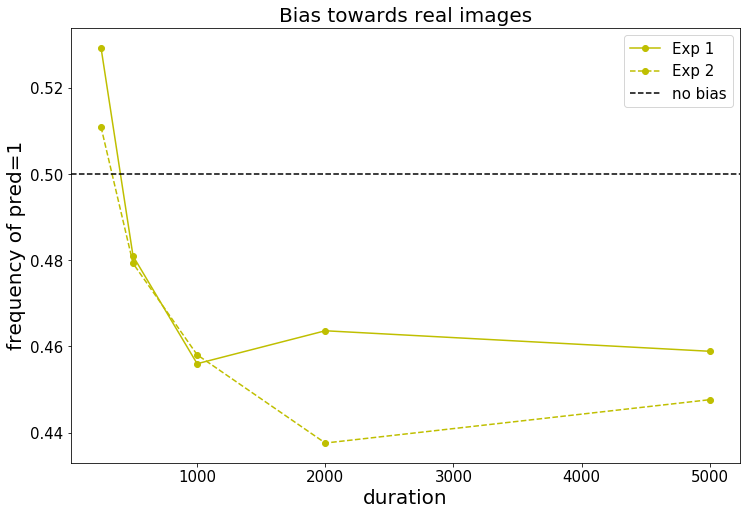

In [10]:
bias_df = df.groupby(['expt_id', 'duration']).pred.mean().reset_index()
fs = 20
tfs = 15

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for expt_id, style in [(1, '-'),(2, '--')]:
    data = bias_df[bias_df.expt_id == expt_id].sort_values(by="duration", ascending=True)
    ax.plot(data.duration, data.pred, color='y', marker="o", linestyle=style, label="Exp %d" % expt_id)
    
ax.axhline(y=0.5, color="k", linestyle="--", label="no bias")
ax.set_title("Bias towards real images", fontsize=fs)
ax.set_xlabel("duration", fontsize=fs)
ax.set_ylabel("frequency of pred=1", fontsize=fs)
ax.legend(loc=0, fontsize=tfs)
ax.xaxis.set_tick_params(labelsize=tfs)
ax.yaxis.set_tick_params(labelsize=tfs)

plt.show()    


In [11]:
img_df = df.groupby('filename').agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
img_df['accuracy'] = img_df.correct / img_df.id


gender_img_df = df.groupby(['filename', 'gender']).agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
gender_img_df['accuracy'] = gender_img_df.correct / gender_img_df.id

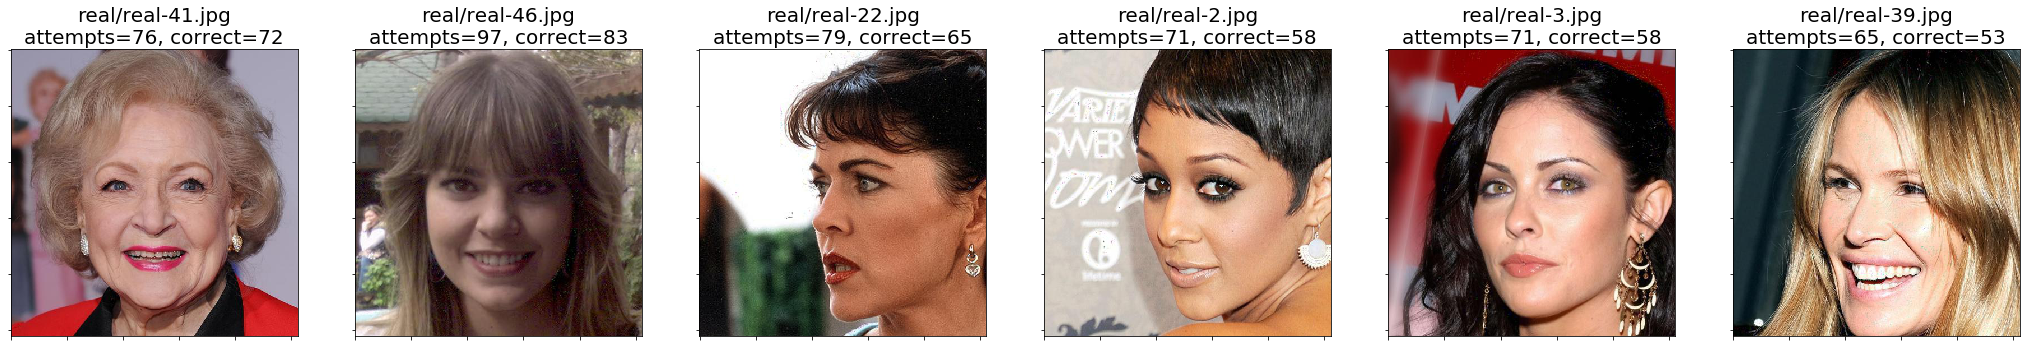

In [12]:
N = 6
expt_id = 1
true = 1
ascending = False

fs = 20

data = img_df[(img_df.true == true) & (img_df.expt_id == expt_id)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

# plt.hist(data.accuracy, bins=10)
# plt.show()

fig = plt.figure(figsize=(36,6))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])), fontsize=fs)
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# fig.savefig('./final_plots/easy_fake_exp1_expert.png')
plt.show()

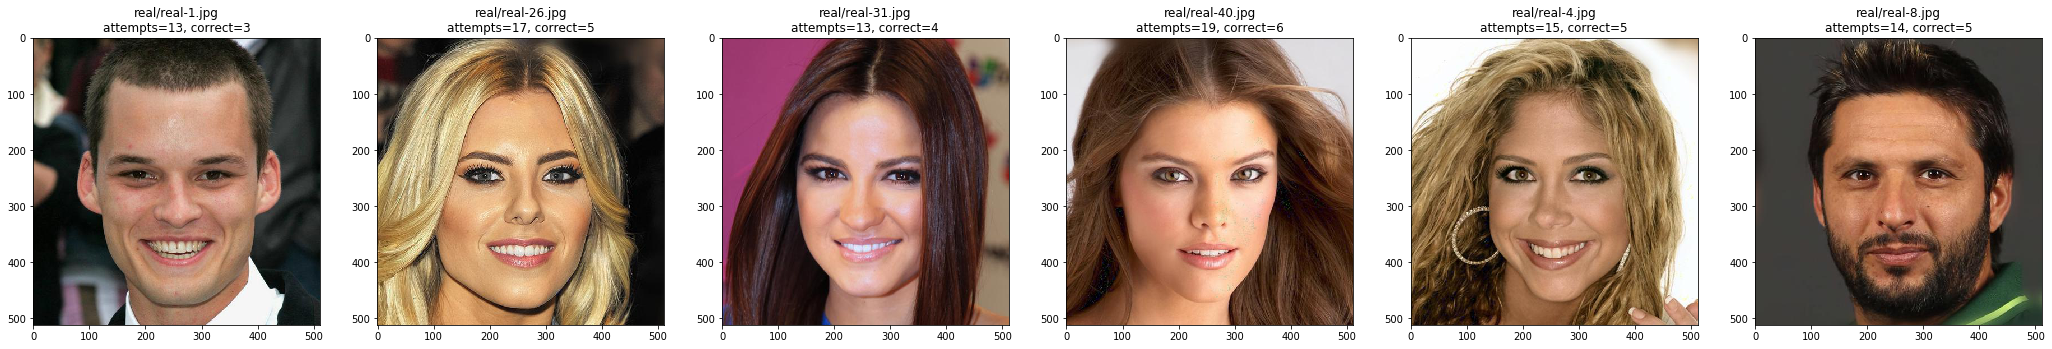

In [13]:
N = 6
true = 1
expt_id = 1
ascending = True
gender = 'female'

data = gender_img_df[(gender_img_df.true == true) & (gender_img_df.expt_id == expt_id) & (gender_img_df.gender == gender)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

fig = plt.figure(figsize=(36,6))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])))
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))

plt.show()